In [1]:
import pandas as pd
import numpy as np

# Bag of Words
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

#Models
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,  accuracy_score

#Grid Search
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

#Competing models
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, make_scorer

#Extra Stop Words corpus
import nltk

#Vsualization
from yellowbrick.text import FreqDistVisualizer

## Data Importing

The movie data is already split in a train and test datasets

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

## Data inspection

Firstly, a data inspection is carried out on the train dataset. It is used to check what kind of variables the dataset contains, if there are missing values and if the grouping of the target level is balanced.

In particular, the aim of the project is to obtain a prediction of the genre based on the text data given by the plot and possibly other features. This is done by checking the accuracy on the test set in the Kaggle competition: https://www.kaggle.com/c/collecting-and-analyzing-big-data-s0k17a

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13164 entries, 0 to 13163
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Release Year      13164 non-null  int64 
 1   Title             13164 non-null  object
 2   Origin/Ethnicity  13164 non-null  object
 3   Director          13164 non-null  object
 4   Cast              12980 non-null  object
 5   Genre             13164 non-null  object
 6   Wiki Page         13164 non-null  object
 7   Plot              13164 non-null  object
dtypes: int64(1), object(7)
memory usage: 822.9+ KB


Checking for missing value, only in the variable cast

In [8]:
train.isna().sum()

Release Year          0
Title                 0
Origin/Ethnicity      0
Director              0
Cast                184
Genre                 0
Wiki Page             0
Plot                  0
dtype: int64

We can see that drama and comedy are the most populated genres, while adventure and crime are the least present ones.

In [9]:
train["Genre"].value_counts()

drama        4781
comedy       3503
horror        937
action        890
thriller      768
romance       743
western       678
crime         442
adventure     422
Name: Genre, dtype: int64

In [5]:
train.sample(3)

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
9183,1996,A Mother's Instinct,American,Sam Pillsbury,Lindsay Wagner,drama,https://en.wikipedia.org/wiki/A_Mother%27s_Ins...,A former divorcé learns that her new husband's...
10069,1971,Support Your Local Gunfighter!,American,Burt Kennedy,"James Garner, Suzanne Pleshette, Harry Morgan",comedy,https://en.wikipedia.org/wiki/Support_Your_Loc...,"Latigo Smith (Garner), a gambler and confidenc..."
12212,1920,Love,American,Wesley Ruggles,"Louise Glaum, James Kirkwood, Sr.",romance,https://en.wikipedia.org/wiki/Love_(1920_film),"A young woman, Natalie Storm (played by Glaum)..."


In [32]:
pd.set_option('display.max_colwidth', -1)
print(train["Plot"].sample(1))

3881    Jennifer Baylor (Lisa Pelikan) is a poor, red-headed young woman from West Virginia. Jennifer possesses a power over snakes, an ability to control them and communicate with them. She and her father, Luke Baylor (Jeff Corey), left their home in disgrace, because when Jennifer was around the age of seven, some snakes she had been handling killed the town preacher's son. She refused to handle snakes ever again, though Luke now runs a pet store and often encourages her to use her power again. Luke is mentally disabled, unable to make meals for himself without burning them, and relies on Jennifer since his wife died. While Luke does run the pet store, he spends most of the time in a back room, listening to Christian radio.\r\nJennifer receives a scholarship to an upper-class girls private school. While at school, Jennifer encounters a clique of wealthy and cruel girls, who hate her for being poor and different. These girls turn others against Jennifer throughout the movie, but Jenni

<ipython-input-32-a88a29b1d8b0>:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


## Baseline

Creating the Baseline method. Firstly, a Count Vectorizer is used to create tokens of the words in the plot descriptions.

In [10]:
#Initialize CountVectorizer
cv_base = CountVectorizer(max_features=1000,  max_df=.9)
#tfidf_transformer_base = TfidfTransformer(smooth_idf=True,use_idf=True)

#Fitting the vectorizer base to the Plot feature
#Train data:
train_cv_base = cv_base.fit_transform(train['Plot'])
#Test Data:
test_cv_base= cv_base.transform(test['Plot'])

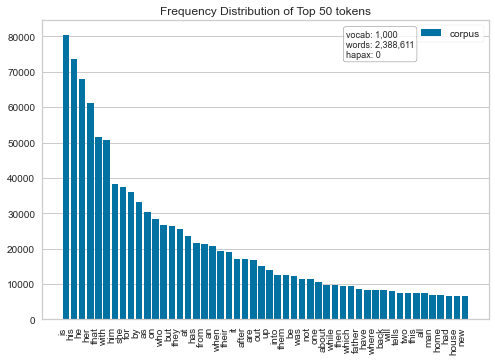

<AxesSubplot:title={'center':'Frequency Distribution of Top 50 tokens'}>

In [11]:
#Visualize the counts of the most used words in our corpus
visualizer = FreqDistVisualizer(features=cv_base.get_feature_names(), orient='v')
visualizer.fit(train_cv_base)
visualizer.show()

Creating the baseline Logistic regression model to solve the classification task

In [53]:
#Create Logisic regression
lr_classifier_base = LogisticRegression(max_iter=1000,solver='liblinear')
#Fiting the Logistic regression with the token features to model the Movie Genre
lr_classifier_base.fit(train_cv_base, train['Genre'])
#Generate predictions with the term frequency object created
prediction_base = lr_classifier_base.predict(train_cv_base)
#Accuracy Score of the model
accuracy_score(train['Genre'],  prediction_base)

C:\Users\fiora\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7492403524764509

In [54]:
print(classification_report(train['Genre'], prediction_base))

              precision    recall  f1-score   support

      action       0.81      0.69      0.75       890
   adventure       0.90      0.77      0.83       422
      comedy       0.73      0.70      0.71      3503
       crime       0.76      0.64      0.69       442
       drama       0.69      0.81      0.74      4781
      horror       0.93      0.89      0.91       937
     romance       0.76      0.57      0.65       743
    thriller       0.82      0.58      0.68       768
     western       0.93      0.91      0.92       678

    accuracy                           0.75     13164
   macro avg       0.81      0.73      0.77     13164
weighted avg       0.76      0.75      0.75     13164



Use test set and after subission we obtain 52.55% accuracy on the test set. From here we try to improve the score on unseen data.

In [55]:
#Predict based on the test set
test["Predicted"] = lr_classifier_base.predict(test_cv_base)
#Export predictions
test[['Id','Predicted']].to_csv('my_submissions_baseline.csv', index=False)

## Baseline Improvements

### Adding Term Frequency times inverse document frequency

Using the Term Frequency times inverse document frequency (TF-IDF) should take into account the frequency of a token found in one movie plot with respect also to the remaining movie plots.

In [10]:
#TF-IDF: Term Frequency times inverse document frequency
tfidf_transformer_base = TfidfTransformer(smooth_idf=True,use_idf=True)
#Train Data:
train_tfidf_base = tfidf_transformer_base.fit_transform(train_cv_base)
#Test Data
test_tfidf_base = tfidf_transformer_base.transform(test_cv_base)

The training accuracy is already worse than with the baseline model.

In [11]:
#Create Logisic regression
lr_classifier_tfidf = LogisticRegression(max_iter=1000,solver='liblinear')
#Fiting the Logistic regression with the token features to model the Movie Genre
lr_classifier_tfidf.fit(train_tfidf_base, train['Genre'])
#Generate predictions with the term frequency object created
prediction_tfidf = lr_classifier_tfidf.predict(train_tfidf_base)
#Accuracy Score of the model
accuracy_score(train['Genre'],  prediction_tfidf)

0.6247341233667578

In [13]:
#Predict based on the test set
test["Predicted"] = lr_classifier_base.predict(test_tfidf_base)
#Export predictions
test[['Id','Predicted']].to_csv('my_submissions_tfidf.csv', index=False)

The accuracy on the test set drops to 35.36%. It does a lot worse than the baseline for the logistic regression.

## Model Improvement with Grid Search

Firstly, a model improvement is search through a **Grid Search** which aims to find the best parameters for the default Logistic regression model. This process is called parameter tuning.

Another improvement in the model is to add a list of **stop_words** in the CountVectorizer. These are common words of the English language, like prepositions, articles and pronouns which do not carry much information for the classifying goal.

In [19]:
#Use the pipeline to chain together different passages.
pipeline = Pipeline([
                     ('vectorizer' , CountVectorizer(stop_words="english")),
                     ('tf_transfomer', TfidfTransformer()),
                     ('classifier' , LogisticRegression(max_iter=1000))
                    ])
#The dictionary of parameters specifies the search space of the grid
parameters = {'vectorizer__max_df' : [.4 , .5, .6, .7 , .8],
              'vectorizer__min_df' : [10, 20, 40],  
              'vectorizer__ngram_range' : [(1,1), (1,2)],
              'tf_transfomer__use_idf': (True, False),
               }
#Making Grid Search
grid_search = GridSearchCV(pipeline,
                           parameters,
                           n_jobs = -1,#Used to parallelize a computation (use all the cores)
                           cv = 5,#along the way make cross validation (data is split in 5 folds, see below)
                           verbose = 1)

In [65]:
grid_search.fit(train['Plot'],train['Genre'])

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 13.2min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer', CountVectorizer()),
                                       ('tf_transfomer', TfidfTransformer()),
                                       ('classifier',
                                        LogisticRegression(max_iter=1000))]),
             n_jobs=-1,
             param_grid={'tf_transfomer__use_idf': (True, False),
                         'vectorizer__max_df': [0.4, 0.5, 0.6, 0.7, 0.8],
                         'vectorizer__min_df': [10, 20, 40],
                         'vectorizer__ngram_range': [(1, 1), (1, 2)],
                         'vectorizer__stop_words': ['english']},
             verbose=1)

Here the best parameter settings from the Grid Search is returned. Indeed, it confirmes that the idf is not needed in this logistic regression model

In [69]:
grid_search.best_params_

{'tf_transfomer__use_idf': False,
 'vectorizer__max_df': 0.4,
 'vectorizer__min_df': 20,
 'vectorizer__ngram_range': (1, 2),
 'vectorizer__stop_words': 'english'}

Train a model according to the Grid Search parameters and obtaining the training accuracy

In [67]:
best_pipe_1 = grid_search.best_estimator_
pipe_prediction_1 = best_pipe_1.predict(train['Plot'])
accuracy_score(train['Genre'],  pipe_prediction_1)

0.7495442114858706

In [68]:
test["Predicted"] = best_pipe_1.predict(test["Plot"])
test[['Id','Predicted']].to_csv('my_submissions_GS1.csv', index=False)

With the model selected with the Grid Search we obtain 60.08% accuracy on the test set, already an improvement from the Baseline model

### Reproducing best model so far from Grid Search

In [3]:
#Best model
cv_best = CountVectorizer(max_df=.4, min_df = 20, ngram_range = (1,2), stop_words = "english")

#Fitting the vectorizer best to the Plot feature
#Train data:
train_cv_best = cv_best.fit_transform(train['Plot'])
#Test Data:
test_cv_best= cv_best.transform(test['Plot'])

#TF-IDF: Term Frequency times inverse document frequency
tfidf_transformer_best = TfidfTransformer(use_idf=False)
#Train Data:
train_tfidf_best = tfidf_transformer_best.fit_transform(train_cv_best)
#Test Data
test_tfidf_best = tfidf_transformer_best.transform(test_cv_best)

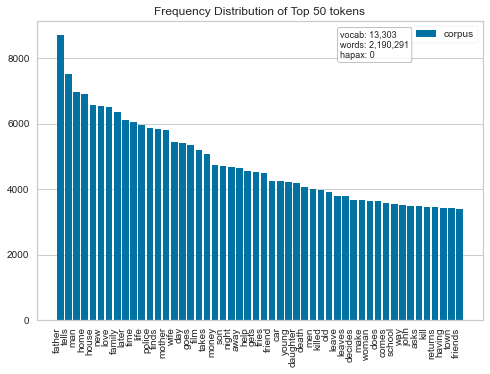

<AxesSubplot:title={'center':'Frequency Distribution of Top 50 tokens'}>

In [22]:
visualizer = FreqDistVisualizer(features=cv_best.get_feature_names(), orient='v')
visualizer.fit(train_cv_best)
visualizer.show()

In [6]:
#Create Logisic regression
lr_classifier_best = LogisticRegression(max_iter=1000, multi_class = "multinomial")
#Fiting the Logistic regression with the token features to model the Movie Genre
lr_classifier_best.fit(train_tfidf_best, train['Genre'])
#Generate predictions with the term frequency object created
prediction_best = lr_classifier_best.predict(train_tfidf_best)
#Accuracy Score of the model
accuracy_score(train['Genre'],  prediction_best)

0.7495442114858706

## Lemmatization

Another way that could increase the amount of information carried by our tokens can be achieved through **Lemmatization** which is used to reduce words to their base grammatical value. 
For instance plurals are returned singulars and verbs are returned conjugated. It is more advanced than stemming, which only reduces the token to its root, but may result in "unreal" words. This potentially will reduce the number of tokens by keeping only 1 common token for different "conjugations" of the same word.

In [4]:
import spacy.cli
spacy.cli.download("en_core_web_md")
nlp = spacy.load("en_core_web_md")

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


Creating a function to apply Lemmatization and joining the tokens of one plot description back together

In [15]:
def lemmatize_string(text):
    # Parse the sentence using the loaded nlp
    doc = nlp(text)
    # Extract the lemma for each token and join
    lem = " ".join([token.lemma_ for token in doc])
    return lem

In [ ]:
train["Lemma Plot"] = train["Plot"].apply(lemmatize_string)
test["Lemma Plot"] = test["Plot"].apply(lemmatize_string)
train_lemma = train.copy()
test_lemma = test.copy()

Since the apply function takes a lot of time, importint the already created dataset is faster

In [5]:
train_lemma = pd.read_csv("train_lemma.csv")
test_lemma = pd.read_csv("test_lemma.csv")

## Grid Search -- Lemmatization Dataset

Applying the previous Grid Search configuration on the dataset with lemmatized plot descriptions

In [22]:
grid_search.fit(train_lemma['Lemma Plot'],train_lemma['Genre'])

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 12.2min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer', CountVectorizer()),
                                       ('tf_transfomer', TfidfTransformer()),
                                       ('classifier',
                                        LogisticRegression(max_iter=1000))]),
             n_jobs=-1,
             param_grid={'tf_transfomer__use_idf': (True, False),
                         'vectorizer__max_df': [0.4, 0.5, 0.6, 0.7, 0.8],
                         'vectorizer__min_df': [10, 20, 40],
                         'vectorizer__ngram_range': [(1, 1), (1, 2)],
                         'vectorizer__stop_words': ['english']},
             verbose=1)

In [23]:
grid_search.best_params_

{'tf_transfomer__use_idf': False,
 'vectorizer__max_df': 0.4,
 'vectorizer__min_df': 20,
 'vectorizer__ngram_range': (1, 2),
 'vectorizer__stop_words': 'english'}

Training the model found from the first grid search to the Lemmatized dataset

In [24]:
best_pipe_2 = grid_search.best_estimator_
pipe_prediction_2 = best_pipe_2.predict(train_lemma['Lemma Plot'])
accuracy_score(train_lemma['Genre'],  pipe_prediction_2)

0.74179580674567

In [25]:
test_lemma["Predicted"] = best_pipe_2.predict(test_lemma["Lemma Plot"])
test_lemma[['Id','Predicted']].to_csv('my_submissions_GS2.csv', index=False)

The accuracy on the test set is 59.96%, which did actually worse than before

## Countvectorizer with Lemmatization

Here the most common words after Lemmatization are shown

In [6]:
#Initialize CountVectorizer with best settings from grid search
cv_lemma = CountVectorizer(min_df=20,  max_df=.4, stop_words = "english", ngram_range= (1,2))
#tfidf_transformer_lemma = TfidfTransformer(smooth_idf=True,use_idf=True)

#Fitting the vectorizer base to the Plot feature
#Train data:
train_cv_lemma = cv_lemma.fit_transform(train_lemma['Lemma Plot'])
#Test Data:
test_cv_lemma= cv_lemma.transform(test_lemma['Lemma Plot'])

#TF-IDF: Term Frequency 
tfidf_transformer_lemma = TfidfTransformer(use_idf=False)
#Train Data:
train_tfidf_lemma = tfidf_transformer_lemma.fit_transform(train_cv_lemma)
#Test Data
test_tfidf_lemma = tfidf_transformer_lemma.transform(test_cv_lemma)

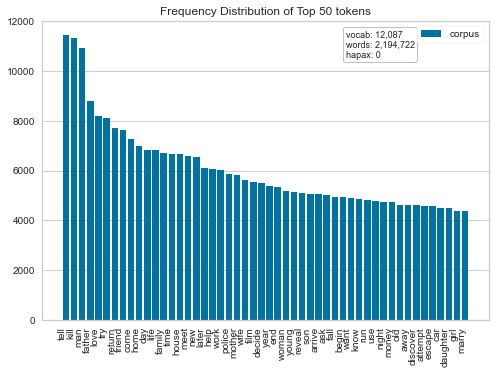

<AxesSubplot:title={'center':'Frequency Distribution of Top 50 tokens'}>

In [28]:
#Visualize the counts of the most used words in the corpus with lemmatization
visualizer = FreqDistVisualizer(features=cv_lemma.get_feature_names(), orient='v')
visualizer.fit(train_cv_lemma)
visualizer.show()

# Competing Models

Now it is time to try different models than the Logistic Regression.

In this section 2 competing models will be experimented: **XGBoost** and **Support Vector Machines**

## XG boost

Here a first competing model is defined. The XGBoost model is proposed as classifier.

In [20]:
xgb = XGBClassifier(silent=False, 
                    booster="gbtree",
                    learning_rate=0.01,  
                    colsample_bytree = 0.4, #typical values 0.5-1
                    subsample = 0.8, #default is 1-smaller values to prevent overfitting
                    objective='multi:softmax ', 
                    num_class = 9, #Number of classes movie genres
                    n_estimators=1000, 
                    reg_lambda = 1, #prevent overfitting
                    reg_alpha = 0.3,
                    max_depth=4, #default 6 (3-10)
                    min_child_weight = 1, #prevent overfitting with higher values
                    eta = 0.3, #Values between 0.01-0.2
                    gamma=0) #Should be tuned 
xgb.fit(train_tfidf_lemma, train["Genre"])

[10:17:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:17:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, eta=0.3, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=8, num_class=9, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0.3,
              reg_lambda=1, scale_pos_weight=None, silent=False, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [22]:
xgb_pred = xgb.predict(train_tfidf_lemma)
accuracy_score(train_lemma['Genre'],xgb_pred)

0.728729869340626

Accuracy on the test set is 55.285%

In [51]:
test_lemma["Predicted"] = xgb.predict(test_tfidf_lemma)
test_lemma[['Id','Predicted']].to_csv('my_submissions_XGBoost_1.csv', index=False)

### Grid Search - XGBoost

In [ ]:
#Use the pipeline to chain together different passages.
pipe2 = Pipeline([
                     ('vectorizer' , CountVectorizer(max_df=.4, stop_words = "english", ngram_range= (1,2))),
                     ('tf_transfomer', TfidfTransformer()),
                     ('clf', XGBClassifier(objective='multi:softmax ', num_class = 9, max_depth=6))
                ])
#Pass a dictionary of parameteres
params2 = {
    
        'clf__min_child_weight': [1, 5],
        'tf_transfomer
        'clf__gamma': [0, 1, 3],
        'clf__colsample_bytree': [0.4, 1.0],
        'clf__max_depth': [3, 6],
        'clf__reg_lambda': [0.6, 1.4]
        }
#Making Grid Search
grid_search2 = GridSearchCV(pipe2,
                           params2,
                           n_jobs = -1,#Used to parallelize a computation 
                           cv = 3,#along the way make cross validation (data is split in 3 folds, see below)
                           verbose = 1,
                           scoring = "accuracy")

In [ ]:
grid_search2.fit(train_lemma['Lemma Plot'],train_lemma['Genre'])

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


In [11]:
grid_search2.best_params_

{'clf__colsample_bytree': 0.4,
 'clf__gamma': 1,
 'clf__max_depth': 6,
 'clf__min_child_weight': 5,
 'clf__reg_lambda': 1.4}

In [12]:
best_xgb_pipe = grid_search2.best_estimator_
xgb_pred_pipe = best_xgb_pipe.predict(train_lemma['Lemma Plot'])
accuracy_score(train_lemma['Genre'],  xgb_pred_pipe)

0.8861288362199939

In [13]:
test_lemma["Predicted"] = best_xgb_pipe.predict(test_lemma["Lemma Plot"])
test_lemma[['Id','Predicted']].to_csv('my_submissions_xbgGS.csv', index=False)

Accuracy on the test is 57.533%

### Applying to the original dataset

Now the best model from the grid search will be tried on the original dataset

In [ ]:
grid_search2.fit(train['Plot'],train['Genre'])

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


In [9]:
grid_search2.best_params_

{'clf__colsample_bytree': 1.0,
 'clf__gamma': 1,
 'clf__max_depth': 6,
 'clf__min_child_weight': 5,
 'clf__reg_lambda': 1.4}

In [10]:
best_xgb_pipe = grid_search2.best_estimator_
xgb_pred_pipe = best_xgb_pipe.predict(train['Plot'])
accuracy_score(train['Genre'],  xgb_pred_pipe)

0.8881798845335764

In [11]:
test["Predicted"] = best_xgb_pipe.predict(test["Plot"])
test[['Id','Predicted']].to_csv('my_submissions_xbgGS2.csv', index=False)

Test accuracy 58.262% which is again better than the one obtained from the lemmatized dataset.

## Support Vector Machine

The final model is a Support Vector Machine (SVM) in this case it fits linear margins between different classes. 

### Baseline

Firstly, a Baseline model is constrcted for the lemma dataset.

In [19]:
SVM = SVC(C=1.0, kernel='linear', gamma='auto')

In [21]:
SVM.fit(train_tfidf_lemma, train_lemma["Genre"])
pred_SVM = SVM.predict(train_tfidf_lemma)
accuracy_score(train_lemma['Genre'],  pred_SVM)

SVC(gamma='auto', kernel='linear')

In [22]:
pred_SVM = SVM.predict(train_tfidf_lemma)
accuracy_score(train_lemma['Genre'],  pred_SVM)

0.8040109389243391

In [25]:
test_lemma["Predicted"] = SVM.predict(test_tfidf_lemma)
test_lemma[['Id','Predicted']].to_csv('my_submissions_SVM.csv', index=False)

Test accuracy 59.356%

Now the model is tried for the original dataset

In [11]:
SVM = SVC(C=1.0, kernel='linear', gamma='auto')

In [12]:
SVM.fit(train_tfidf_best, train["Genre"])
pred_SVM = SVM.predict(train_tfidf_best)
accuracy_score(train['Genre'],  pred_SVM)

0.8190519598906107

In [13]:
test["Predicted"] = SVM.predict(test_tfidf_best)
test[['Id','Predicted']].to_csv('my_submissions_SVM2.csv', index=False)

Test accuracy 60.449%. Which is a slight improvement from the best one found with the Logistic regression

### Grid Search

Once again now a grid search to evaluate several hyperparameters is tried on the original dataset.

The long training time for this model poses also a challange and limits the search space that can feasibly be investigated on this machine

This time the stopwords are tried to be obtained from the NLTK package

In [4]:
#Setting stopwords from the NLTK package
nltk.download('stopwords')
en_stopwords = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fiora\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
#Use the pipeline to chain together different passages.
pipe4 = Pipeline([
                     ('vectorizer' , CountVectorizer(stop_words = en_stopwords, ngram_range= (1,2))),
                     ('tf_transfomer', TfidfTransformer()),
                     ('clf', SVC(kernel = "linear", class_weight="balanced"))
                ])

#Pass a dictionary of parameteres
params4 = {
        'vectorizer__max_df': [0.4,0.7],
        'clf__C': [0.9, 1], # Regularization parameter. The strength of the regularization is inversely proportional to C
        'tf_transfomer__use_idf': (True, False)
        
}
#Making Grid Search
grid_search4 = GridSearchCV(pipe4,
                           params4,
                           n_jobs = -1,#Used to parallelize a computation (use all the cores)
                           cv = 3,#along the way make cross validation (data is split in 3 folds, see below)
                           verbose = 1)

In [6]:
grid_search4.fit(train['Plot'],train['Genre'])

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 28.6min finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vectorizer',
                                        CountVectorizer(ngram_range=(1, 2),
                                                        stop_words={'a',
                                                                    'about',
                                                                    'above',
                                                                    'after',
                                                                    'again',
                                                                    'against',
                                                                    'ain',
                                                                    'all', 'am',
                                                                    'an', 'and',
                                                                    'any',
                                                                    'are',
    

Interestingly, for the SVM the idf is returned True

In [7]:
grid_search4.best_params_

{'clf__C': 1, 'tf_transfomer__use_idf': True, 'vectorizer__max_df': 0.4}

Here we have a very high accuracy on the training set, which may be due to overfitting

In [8]:
best_svm_pipe4 = grid_search4.best_estimator_
svm_pred_pipe4 = best_svm_pipe4.predict(train['Plot'])
accuracy_score(train['Genre'],  svm_pred_pipe4)

0.9502430872075357

In [9]:
test["Predicted"] = best_svm_pipe4.predict(test['Plot'])
test[['Id','Predicted']].to_csv('my_submissions_SVM__GS7.csv', index=False)

Test accuracy is 60.692% which is the best one found!

It would be interesting to extend the grid search and test different parameter configurations, but the training time and the limited capacity of the machine create obstacles in this goal. A solution is to bring the analysis on an external server with stronger capacities.